In [1]:
import torch
import time 
import copy
import os
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
data_dir = r"D:\Fastai\dl2\data\train"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 16
validation_split = 0.2
shuffle_dataset = True
random_seed = 21

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
print(len(image_dataset))

1023


Dataset was made using this handy function from the second lesson of Fastai Tutorial

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [4]:
dataset_size = len(image_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    image_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(
    image_dataset, batch_size=batch_size, sampler=valid_sampler)

dataloaders = {'train': train_loader, 'val': validation_loader}
datasets_sizes = {
    'train': len(train_loader) * batch_size,
    'val': len(validation_loader) * batch_size
}
print(datasets_sizes)

{'train': 832, 'val': 208}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


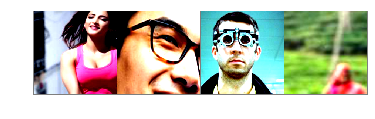

In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))

In [6]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

for param in resnet50.parameters():
    param.requires_grad = False
    
resnet50.fc = nn.Sequential(
                      nn.Linear(2048, 256), 
                      nn.ReLU(), 
                      nn.Linear(256, 2)
)
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

In [7]:
def train_model(model, criterion, optimiser, num_epochs=10):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #training model
            else:
                model.eval() #evaluating model
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimiser.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimiser.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / datasets_sizes[phase]
            epoch_acc = running_corrects.double() / datasets_sizes[phase]
            
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
    
    time_consumed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_consumed // 60, time_consumed % 60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
%time model_ft = train_model(resnet50, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5712 Accuracy: 0.6959
val Loss: 0.3157 Accuracy: 0.8606

Epoch 1/19
----------
train Loss: 0.4148 Accuracy: 0.7909
val Loss: 0.2564 Accuracy: 0.9087

Epoch 2/19
----------
train Loss: 0.3894 Accuracy: 0.8137
val Loss: 0.2550 Accuracy: 0.9038

Epoch 3/19
----------
train Loss: 0.3616 Accuracy: 0.8365
val Loss: 0.3313 Accuracy: 0.8654

Epoch 4/19
----------
train Loss: 0.3810 Accuracy: 0.8089
val Loss: 0.2490 Accuracy: 0.9135

Epoch 5/19
----------
train Loss: 0.3379 Accuracy: 0.8353
val Loss: 0.2333 Accuracy: 0.9038

Epoch 6/19
----------
train Loss: 0.2950 Accuracy: 0.8582
val Loss: 0.2343 Accuracy: 0.8990

Epoch 7/19
----------
train Loss: 0.3139 Accuracy: 0.8474
val Loss: 0.3496 Accuracy: 0.8221

Epoch 8/19
----------
train Loss: 0.3495 Accuracy: 0.8269
val Loss: 0.2751 Accuracy: 0.8654

Epoch 9/19
----------
train Loss: 0.3378 Accuracy: 0.8450
val Loss: 0.2419 Accuracy: 0.8798

Epoch 10/19
----------
train Loss: 0.3182 Accuracy: 0.8474
val Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


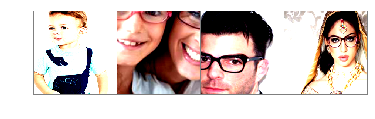

GroundTruth:  no-glasses glasses glasses glasses


In [12]:
classes = ['glasses', 'no-glasses']
dataiter = iter(validation_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
output = model_ft(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  no-glasses glasses glasses glasses


In [21]:
torch.save(model_ft, r"C:\Users\Siddhant\model.pth")

In [11]:
# dummy_input = torch.randn(16, 3, 224, 224)

# input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
# output_names = [ "output1" ]

# torch.onnx.export(model_ft, dummy_input, "glasses_model", verbose=True, input_names=input_names, output_names=output_names)